===== Logistic Regression =====
Accuracy: 0.824
ROC-AUC: 0.906

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86       163
           1       0.70      0.85      0.77        87

    accuracy                           0.82       250
   macro avg       0.81      0.83      0.81       250
weighted avg       0.84      0.82      0.83       250


===== Random Forest =====
Accuracy: 0.792
ROC-AUC: 0.891

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85       163
           1       0.80      0.54      0.64        87

    accuracy                           0.79       250
   macro avg       0.79      0.73      0.75       250
weighted avg       0.79      0.79      0.78       250



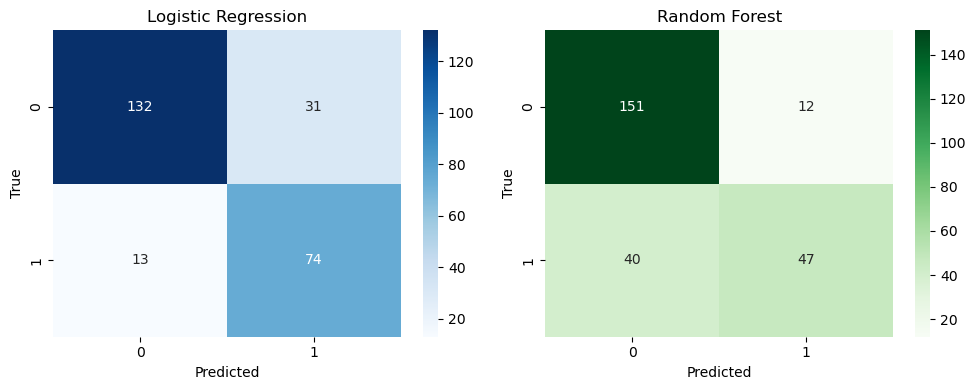

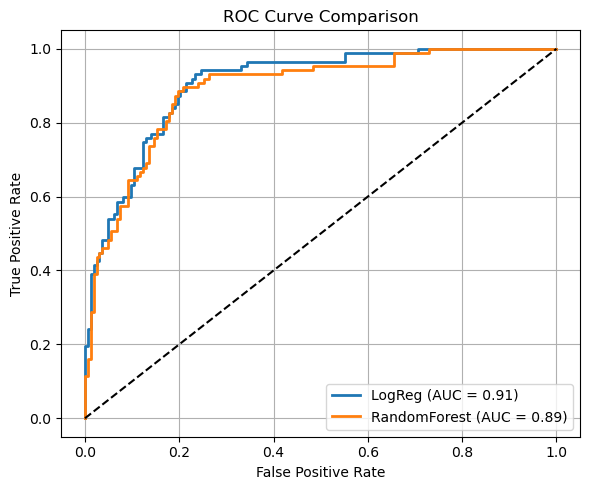

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from sklearn.impute import SimpleImputer

# ---------- 1) Load ----------
df = pd.read_csv("../data/healthcare_dataset.csv")

# If labels are strings like "Low"/"High", map to 0/1 (skip if already 0/1)
if df["RiskLabel"].dtype == object:
    df["RiskLabel"] = df["RiskLabel"].map({"Low": 0, "High": 1})

# Keep only numeric features for this simple baseline
X_all = df.drop("RiskLabel", axis=1)
num_cols = X_all.select_dtypes(include=[np.number]).columns
X = X_all[num_cols].copy()
y = df["RiskLabel"].astype(int)

# Impute missing values in numeric features
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=num_cols)

# ---------- 2) Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ---------- 3) Scale for Logistic Regression ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- 4) Logistic Regression ----------
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# ---------- 5) Random Forest (no scaling needed) ----------
rf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# ---------- 6) Evaluate ----------
print("===== Logistic Regression =====")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_lr), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

print("\n===== Random Forest =====")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_rf), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# ---------- 7) Confusion Matrices ----------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.savefig("confusion-matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------- 8) ROC Curves ----------
from sklearn.metrics import RocCurveDisplay
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()